<h1 align="center">KDD Cup 1999 Model</h1>

<hr style="border-top: 2px solid #444">

## Development Environment
In this section, the development environment for this Jupyter notebook project is prepared by collecting Python dependencies, importing libraries, and configuring the runtime environment.

### Python Dependencies
External Python dependencies are collected through the [Pipenv](https://pypi.org/project/pipenv/) package manager since it supports dependency lock-files. In the following script, `pipenv` and its transitive dependencies are installed from `pipenv-requirements.txt` and then the notebook's dependencies are installed from `Pipfile` and `Pipfile.lock`.

In [1]:
#!pip install -r pipenv-requirements.txt
#!pipenv install

### Library Imports
All internal standard libraries and external libraries are imported here, with some stated dependency versions.

In [2]:
import gzip
import re
import pandas
import numpy
import requests
import tensorflow
from enum import Enum
from os import path
import matplotlib.pyplot as pyplot


### Configure PRNG Seed
Numpy, Tensorflow, and SciKit rely on [pseudorandom number generators](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) as their internal source for randomness. To guarantee deterministic behaviour and reproducible results for this notebook's execution, an arbitrary seed is configured.

In [3]:
PRNG_SEED = 42

numpy.random.seed(PRNG_SEED)
tensorflow.random.set_seed(PRNG_SEED)

<hr style="border-top: 2px solid #444">

## I. Data Importation

Source: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [4]:
# create 'data' cache directory
if not path.exists('data'):
    path.makedirs('data')

### Fetch Column Types: Categorical vs Continuous

In [5]:
DATASET_COLUMNS_FILE = path.join("data", "kddcup1999_columns.txt")

if not path.exists(DATASET_COLUMNS_FILE):
    with requests.get("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names") as request:
        with open(DATASET_COLUMNS_FILE, 'wb') as file:
            file.write(request.content)

### Fetch Labeled CSV Dataset

In [6]:
DATASET_URL = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz"
DATASET_FILE = path.join("data", "kddcup1999.csv")

# download dataset if not already cached
if not path.exists(DATASET_FILE):
    with requests.get(DATASET_URL) as response:
        if response.status_code != 200:
            raise RuntimeError(f"failed to download dataset: {DATASET_URL}")
        # decompress content
        with open(DATASET_FILE, 'wb') as file:
            file.write(gzip.decompress(response.content))

### Load Column Types

In [7]:
ColumnType = Enum('ColumnType', 'SYMBOLIC CONTINUOUS')
column_types = {}

with open(DATASET_COLUMNS_FILE, 'r') as file:
    column_labels: str = file.read()

column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[1:]:
    match = column_regex.match(column_type)
    column_types[match.group("column_name")] = ColumnType[match.group("data_type").upper()]

### Load CSV Dataset

In [8]:
dataframe = pandas.read_csv(
    # file to import from
    DATASET_FILE,
    # important to specify the CSV file contains no headers
    # otherwise, the first record is interpreted as a header
    header = None,
)
dataframe.columns = [*column_types.keys(), "outcome"]

pandas.set_option('display.max_rows', 10)
dataframe

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


<hr style="border-top: 2px solid #444">

## II. Inspecting Dataset

### Normal vs Intrusions

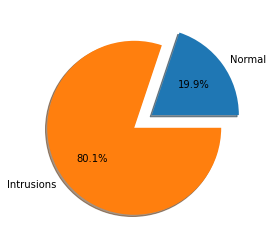

In [9]:
type_frequencies = dataframe['outcome'].value_counts()
normal_frequency = type_frequencies['normal.']
intrusion_frequency = sum([count for outcome_type, count in type_frequencies.iteritems() if outcome_type != 'normal.'])

figure = pyplot.figure()
pyplot.pie(
    [normal_frequency, intrusion_frequency],
    labels=['Normal', 'Intrusions'],
    explode=[0, .25],
    autopct='%1.1f%%',
    shadow=True,
)
pyplot.show()

### Intrusion Frequency
Heavily skewed; a visualization does not properly capture the frequency (barring a logarithmic graph)

In [10]:
intrusion_frequencies=type_frequencies.drop(labels=["normal."])

pandas.set_option('display.max_rows', None)
pandas.DataFrame(
    intrusion_frequencies.values,
    columns=['frequency'],
    index=[intrusion_name[:-1] for intrusion_name in intrusion_frequencies.index]
).sort_values(by="frequency", ascending=False)

,frequency
smurf,2807886
neptune,1072017
satan,15892
ipsweep,12481
portsweep,10413
nmap,2316
back,2203
warezclient,1020
teardrop,979
pod,264


<hr style="border-top: 2px solid #444">

## III. Data Preprocessing

### One-hot-encode Discrete Columns

### Normalize Continuous Columns

### Binary Intrusion Classification

#### Input Features

#### Output Features

### Intrusion Classification

#### Input Features

#### Output Features

<hr style="border-top: 2px solid #444">

## IV. Intrusion Detection - Binary Classification Model

### Create Model

### Train Model

### Model Accuracy

#### Model Predictions

#### Error Scoring

### Feature Importance

<hr style="border-top: 2px solid #444">

## V. Intrusion Type - Classification Model

### Create Model

### Train Model

### Model Accuracy

#### Model Predictions

#### Error Scoring

### Feature Importance

<hr style="border-top: 2px solid #444">

## VI. Conclusion